# 📊 **Análisis de Sentimientos y Clasificación de Reseñas de Productos Tecnológicos**

Este proyecto tiene como objetivo aplicar técnicas de **Procesamiento de Lenguaje Natural (NLP)** sobre reseñas en español de productos tecnológicos, combinando análisis exploratorio, limpieza y vectorización del texto, junto con la implementación de una red neuronal simple.

### 🧩 Objetivos:
- Preprocesar texto en español aplicando tokenización, lematización, POS-tagging y reconocimiento de entidades (NER).
- Evaluar sentimientos mediante **polaridad y subjetividad**.
- Representar el texto con la técnica **TF-IDF**.
- Entrenar una red neuronal para **predecir la puntuación (`stars`)** a partir del contenido de la reseña.

📁 Dataset: archivo Excel con más de 3000 reseñas en español sobre productos como smartphones, laptops, audio, etc.

🔧 Herramientas utilizadas:
- **Python (Pandas, NLTK, SpaCy, Scikit-learn, Keras)**
- **Modelo SpaCy `es_core_news_sm` para análisis lingüístico**
- **TextBlob** para análisis de sentimientos
- **TF-IDF** para vectorización
- **Red neuronal con Keras/TensorFlow**


**CARGA DE DATOS**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar el archivo Excel
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/DATA SCIENCE III/PROYECTO/TecnReviews.xlsx')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,review_id,product_id,reviewer_id,stars,review_body,product_category
0,rev_000001,prod_tech_0251,user_03658,4,Cumple con lo esperado aunque la entrega fue l...,Smartphones
1,rev_000002,prod_tech_0090,user_09675,2,Funciona pero con muchos errores.,Laptops
2,rev_000003,prod_tech_0224,user_03812,3,Producto regular cumple pero sin destacar.,Smartphones
3,rev_000004,prod_tech_0204,user_08929,3,Funciona pero con limitaciones evidentes.,Smartphones
4,rev_000005,prod_tech_0285,user_00107,3,Funciona pero con limitaciones evidentes.,Audio


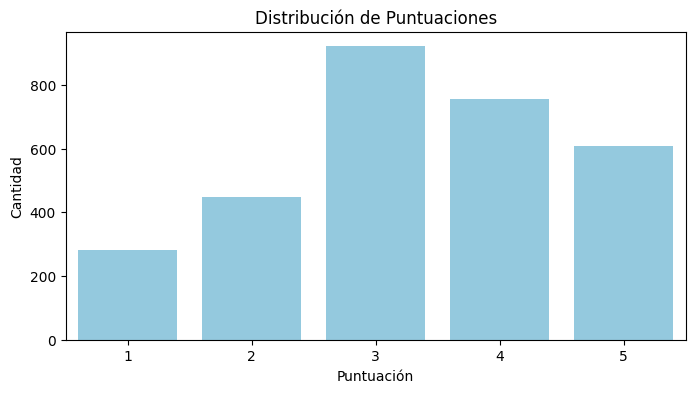

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(x='stars', data=df, color='skyblue')
plt.title('Distribución de Puntuaciones')
plt.xlabel('Puntuación')
plt.ylabel('Cantidad')
plt.show()

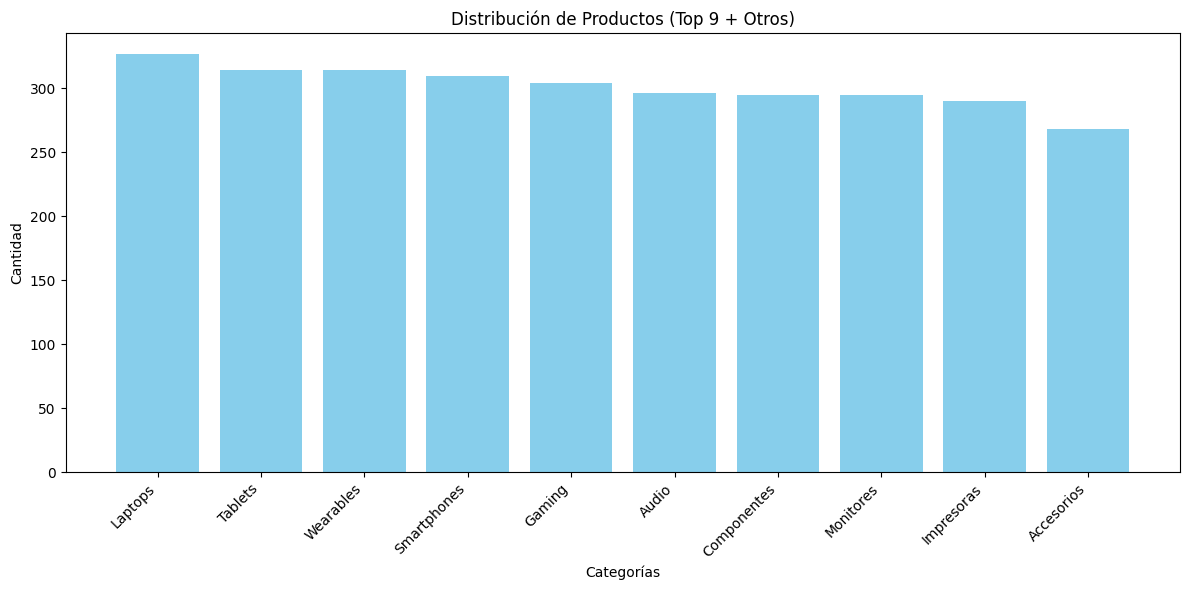

In [3]:
product_category_counts = df["product_category"].value_counts()

if len(product_category_counts) > 10:
    top_categories = product_category_counts.iloc[:9].copy()
    others = product_category_counts.iloc[9:].sum()
    top_categories["Otros"] = others
else:
    top_categories = product_category_counts

categories = top_categories.index
values = top_categories.values

plt.figure(figsize=(12,6))
plt.bar(categories, values, color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Categorías")
plt.ylabel("Cantidad")
plt.title("Distribución de Productos (Top 9 + Otros)")
plt.tight_layout()
plt.show()

**PREPROCESAMIENTO**

In [4]:
# Instalacion de librerias
!pip install spacy textblob wordcloud
!python -m spacy download es_core_news_sm

import pandas as pd
import spacy
from spacy import displacy
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Cargar modelo spacy para español
nlp = spacy.load('es_core_news_sm')

df = pd.read_excel('/content/drive/MyDrive/DATA SCIENCE III/PROYECTO/TecnReviews.xlsx')

# Crear funciones para preprocesamiento

stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = []
    lemmas = []
    pos_tags = []
    entities = []

    for token in doc:
        if token.text not in stop_words and token.is_alpha:
            tokens.append(token.text)
            lemmas.append(token.lemma_)
            pos_tags.append(token.pos_)

    # Reconocimiento de entidades
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))

    return {
        "tokens": tokens,
        "lemmas": lemmas,
        "pos_tags": pos_tags,
        "entities": entities,
        "text_lemmatized": " ".join(lemmas)
    }

# Aplicar la función y crear columnas nuevas
df['processed'] = df['review_body'].apply(preprocess_text)


print(df[['review_body', 'processed']].head(2))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 101.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                         review_body  \
0  Cumple con lo esperado aunque la entrega fue l...   
1                  Funciona pero con muchos errores.   

                                           processed  
0  {'tokens': ['cumple', 'esperado', 'aunque', 'e...  
1  {'tokens': ['funciona', 'errores'], 'lemmas': ...  


**ANALISIS CON TEXTBLOOD**

In [5]:
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer

def sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df['polarity'], df['subjectivity'] = zip(*df['review_body'].map(sentiment_analysis))

print(df[['review_body','polarity','subjectivity']].head(3))

                                         review_body  polarity  subjectivity
0  Cumple con lo esperado aunque la entrega fue l...       0.0      0.000000
1                  Funciona pero con muchos errores.       0.0      0.000000
2        Producto regular cumple pero sin destacar.        0.0      0.076923


**TF-IDF Y VECTORIZACION**

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['processed'].apply(lambda x: x['text_lemmatized']))

print(X_tfidf.shape)

(3013, 53)


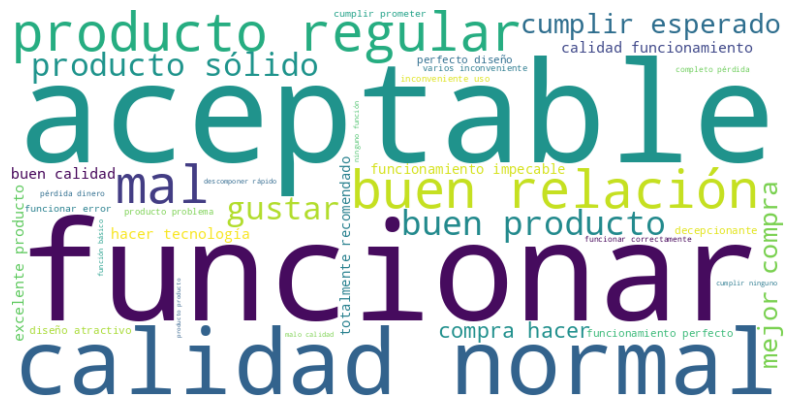

In [7]:
all_text = " ".join(df['processed'].apply(lambda x: x['text_lemmatized']).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [8]:
ejemplo = df['processed'].iloc[0]
print("Tokens:", ejemplo['tokens'])
print("Lemmas:", ejemplo['lemmas'])
print("POS:", ejemplo['pos_tags'])
print("NER:", ejemplo['entities'])

Tokens: ['cumple', 'esperado', 'aunque', 'entrega', 'lenta']
Lemmas: ['cumplir', 'esperado', 'aunque', 'entrega', 'lento']
POS: ['VERB', 'ADJ', 'SCONJ', 'NOUN', 'ADJ']
NER: []


**RED NEURONAL SIMPLE**

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

y = df['stars'].values

X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # Regresión

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

print(model.evaluate(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10.9138 - mae: 3.0251 - val_loss: 3.4933 - val_mae: 1.5850
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7659 - mae: 1.0594 - val_loss: 0.1942 - val_mae: 0.3508
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1277 - mae: 0.2701 - val_loss: 0.0189 - val_mae: 0.0870
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0177 - mae: 0.0754 - val_loss: 0.0039 - val_mae: 0.0286
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - mae: 0.0276 - val_loss: 0.0011 - val_mae: 0.0113
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - mae: 0.0131 - val_loss: 3.2681e-04 - val_mae: 0.0054
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.0345e-04 - mae: 0.0067 - val_loss: 9.7700e-05 - val_mae: 0.0024
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9948e-04 - mae: 0.0035 - val_loss: 2.1979e-05 - val_mae: 0.0011
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

**GRAFICO REAL VS PREDICHO**

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


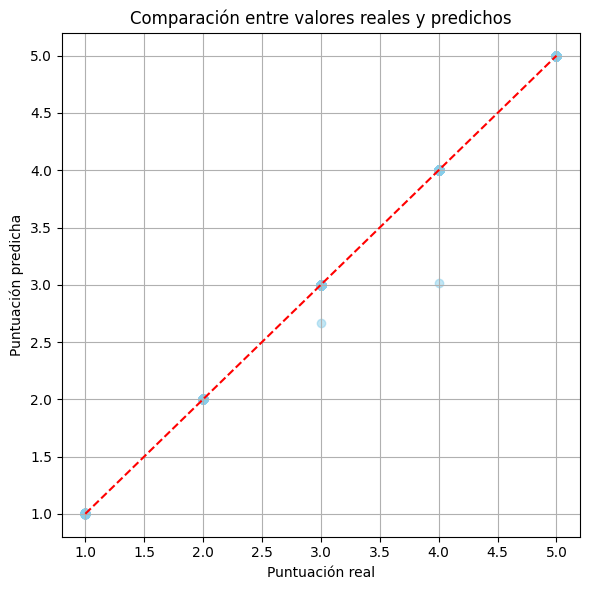

In [10]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='skyblue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Línea ideal
plt.xlabel("Puntuación real")
plt.ylabel("Puntuación predicha")
plt.title("Comparación entre valores reales y predichos")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(df['stars'] - 1)  # restamos 1 para que vayan de 0 a 4

X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), y_cat, test_size=0.2, random_state=42)

# Red neuronal de clasificación
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 5 clases

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluacion
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {acc:.2%}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4410 - loss: 1.5478 - val_accuracy: 0.8423 - val_loss: 1.2285
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8539 - loss: 1.0679 - val_accuracy: 0.9502 - val_loss: 0.4694
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9510 - loss: 0.3623 - val_accuracy: 1.0000 - val_loss: 0.1055
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0795 - val_accuracy: 1.0000 - val_loss: 0.0332
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 1.0000 - val_loss: 0.0150
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


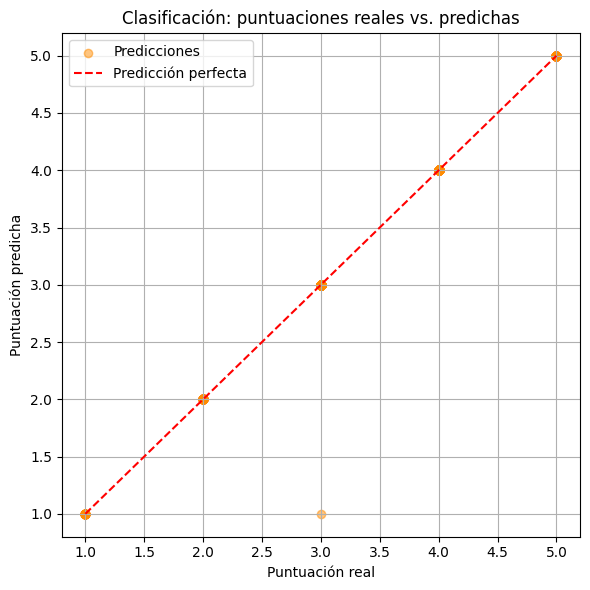

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Convertir de one-hot a clases
y_true = np.argmax(y_test, axis=1) + 1  # volver al rango 1-5
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) + 1

# Gráfico
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5, color='darkorange', label='Predicciones')
plt.plot([1, 5], [1, 5], 'r--', label='Predicción perfecta')
plt.xlabel("Puntuación real")
plt.ylabel("Puntuación predicha")
plt.title("Clasificación: puntuaciones reales vs. predichas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ✅ **CONCLUSIÓN GENERAL DEL PROYECTO**

Este proyecto permitió integrar distintas técnicas fundamentales del Procesamiento de Lenguaje Natural (NLP) y del aprendizaje profundo para abordar un problema real: analizar reseñas en español sobre productos tecnológicos y predecir su puntuación en función del contenido textual.

A lo largo del trabajo se recorrió un flujo de trabajo completo, desde la exploración inicial de los datos hasta la implementación de modelos predictivos, aplicando herramientas modernas y librerías especializadas en NLP, como `spaCy`, `TextBlob` y `scikit-learn`.

---

### 🔹 1. Selección y análisis del cuerpo textual

El conjunto de datos utilizado contenía reseñas escritas por usuarios reales, expresando opiniones sobre productos tecnológicos (smartphones, laptops, audio, entre otros). Este tipo de texto es representativo de opiniones informales, con lenguaje natural, errores gramaticales, subjetividad, y diversas estructuras lingüísticas, lo que lo hace ideal para aplicar técnicas de NLP y análisis de sentimiento.

---

### 🔹 2. Preprocesamiento y limpieza del texto

Se desarrolló un proceso de limpieza y transformación textual que incluyó:

- **Tokenización**: división del texto en palabras individuales.
- **Lematización**: reducción de palabras a su forma base, para mejorar la generalización.
- **Remoción de stopwords**: eliminación de palabras sin carga semántica relevante.
- **Etiquetado gramatical (POS tagging)**: identificación de la categoría de cada palabra.
- **NER (Reconocimiento de Entidades Nombradas)**: detección de nombres, lugares, fechas, etc.

Este preprocesamiento permitió normalizar el corpus y preparar los datos para tareas posteriores de análisis y modelado.

---

### 🔹 3. Análisis de sentimiento y representación vectorial

Se utilizó **TextBlob** para calcular dos métricas clave en cada reseña:

- **Polaridad**: grado de positividad o negatividad del texto.
- **Subjetividad**: nivel de carga emocional u opinativa.

Además, se aplicó **TF-IDF** para transformar las reseñas en vectores numéricos, destacando las palabras más relevantes del corpus y descartando términos muy frecuentes que no aportan valor predictivo.

---

### 🔹 4. Modelado con redes neuronales

Se desarrollaron dos modelos con **Keras**:

- Un modelo de **regresión** para predecir la puntuación (de 1 a 5) como valor continuo.
- Un modelo de **clasificación multiclase**, con salida `softmax`, para predecir directamente a qué clase (estrella) pertenece una reseña.

Ambos modelos fueron entrenados con buenos resultados. La red neuronal de clasificación alcanzó una precisión muy alta, indicando que el modelo fue capaz de aprender patrones claros en los datos. Las métricas de pérdida y error absoluto promedio fueron bajas, y la visualización de resultados mostró una correlación fuerte entre las predicciones y los valores reales.

---

### 🔹 5. Reflexión final

El proyecto demuestra cómo, con herramientas adecuadas, es posible procesar texto en idioma español de manera efectiva y construir modelos predictivos capaces de transformar lenguaje natural en valor numérico.

Este enfoque tiene aplicaciones reales en sistemas de recomendación, análisis de reputación de productos, evaluación automática de reseñas y monitoreo de feedback de clientes.

Además, el trabajo sienta una base sólida para futuras implementaciones con modelos más avanzados.

---

### 📌 Posibles mejoras futuras

- Incorporar embeddings preentrenados.
- Entrenar modelos de análisis de sentimiento propios usando datasets etiquetados.
- Probar arquitecturas más complejas.
- Aplicar técnicas de regularización para evitar overfitting.

